In [787]:
cd /home/dsi/mbouchouia/code/git/PRIM/Notebooks/

/home/dsi/mbouchouia/code/git/PRIM/Notebooks


In [191]:
import sklearn
import itertools
import tensorflow as tf

In [5]:
import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import urllib

In [686]:
import time
import sys
import pymongo
import os
sys.path.append('../scripts/')

import Plotting
import folium
import matplotlib
import osmMerger
import CustomUtils
import OsmProcessing
import pandas as pd
from functools import reduce
import seaborn as sns
sns.set()
results_path = "../images/model results/"
def saveFig():
    if not os.path.isdir(results_path+model_name):
        os.makedirs(results_path+model_name)
    print(results_path+model_name)
    plt.savefig(results_path+model_name+input(),dpi=300,bbox_inches='tight')

In [7]:
# mergeResults,segmentsMeta, mergedSegments= osmMerger.mergeSegments(minValidData = osmMerger.MIN_VALID_DATA, weights=osmMerger.WEIGHTS,speedsMx=speeds)
# mergeResults.to_pickle("../data/mergeResults.pckl")
# segmentsMeta.to_pickle("../data/segmentsMeta.pckl")

In [8]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")

In [9]:
from importlib import reload

In [10]:
from models import *

In [11]:
speeds = pd.read_pickle("../data/monthsSpeed.pckl")
counts = pd.read_pickle('../data/monthsCount.pckl')
data_cleaner = DataCleaner(speeds,segmentsMeta,mergeResults,counts)

In [12]:
speedDF = data_cleaner.data
countDF = data_cleaner.counts

In [13]:
adjacency_matrix = OsmProcessing.getAdjacencyMatrix(segmentsMeta)
adjacency_matrix = OsmProcessing.addLevel(adjacency_matrix,1)
adjacency_matrix=OsmProcessing.mergeAdjacencyMatrix(adjacency_matrix, mergeResults,segmentsMeta)
adjacency_matrix=adjacency_matrix[speedDF.index].loc[speedDF.index]

In [ ]:
def createMlpModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):

    model = tf.keras.models.Sequential()
    #layers
    model.add(tf.keras.layers.Flatten())
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.Dense(neuronsPerLayer*(i+1)))
    model.add(tf.keras.layers.Dense(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

def createStackedLstmModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):
    model = tf.keras.models.Sequential()
    #layers
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.LSTM(neuronsPerLayer*(i+1),return_sequences=True))
    model.add(tf.keras.layers.LSTM(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
build_grid= {'optimizer':['Adam'],
              'nlayers':[0,1,3],
              'neuronsPerLayer':[64],
              'loss':['MSE','MAE'],
              'relu_output':[False]
             }

train_grid={
    "batch_size":[8,32,64], 
    "epochs":[100], 
    "validation_split":[0.5]
}

preprocess_grid={
    'scale_Max':[True],
    'scale_log':[False],
    'input_lag':[1,6],
    'output_lag':[1],
    'time_as_input':[True],
    "validation_split":[0.5]

}

def getParamsFromGrid(grid):
    return [dict(list(zip(list(grid.keys()),x ))) for x in list(itertools.product(*list(grid.values())))]

def grid_search(data,buildfunc,build_grid,train_grid,preprocess_grid):

    grid = list(itertools.product( getParamsFromGrid(build_grid),
                                   getParamsFromGrid(train_grid),
                                   getParamsFromGrid(preprocess_grid)
                                 )
               )
    
    losses=[]
    val_losses=[]
    mseLoss=[]
    mseValLoss=[]
    for build_param,train_param,preprocess_param in grid :
        print(build_param,train_param,preprocess_param)
        x,y = preprocessData(data,**preprocess_param)
        xtrain = x[:int(len(x)*(train_param['validation_split']))]
        xtest = x[int(len(x)*(train_param['validation_split'])):]
        ytrain = y.reshape(-1,nSegments)[:int(len(x)*(train_param['validation_split']))]
        ytest = y.reshape(-1,nSegments)[int(len(x)*(train_param['validation_split'])):]
        tf.keras.backend.clear_session()
        tf.keras.backend.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)))

        model=buildfunc(**build_param)
        model.fit(xtrain,ytrain.reshape(-1,nSegments),validation_data = (xtest,ytest), **train_param,verbose=0)
        
        losses.append(model.evaluate(xtrain,ytrain,verbose=0))
        val_losses.append(model.evaluate(xtest,ytest,verbose=0))
        
        mseLoss.append(mse(reversePreProcess(ytrain,**preprocess_param),reversePreProcess(model.predict(xtrain),**preprocess_param)))
        mseValLoss.append(mse(reversePreProcess(ytest,**preprocess_param),reversePreProcess(model.predict(xtest),**preprocess_param)))
        print(losses[-1],val_losses[-1],mseLoss[-1],mseValLoss[-1])
        
    resDF=pd.DataFrame(list(zip(grid,losses,val_losses,mseLoss,mseValLoss)),columns=['params','loss_value','val_loss_value','mseLoss','mseValLoss'])
    
    return  pd.concat([resDF.params.apply(lambda x : pd.Series({**x[0],**x[1],**x[2]})),resDF[['loss_value','val_loss_value','mseLoss','mseValLoss']]],axis=1)


In [ ]:
# resMlpDF = grid_search(data,createMlpModel,build_grid,train_grid,preprocess_grid)

In [ ]:
# resLstmDF.groupby("time_as_input")['mseLoss'].describe()

In [ ]:
# resLstmDF = grid_search(data,createStackedLstmModel,build_grid,train_grid,preprocess_grid)

In [182]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""
def multiInputMultiOutputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:], name="speed_input")
    lstm = tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(nSegments,name="lstm_branch")(lstm)

    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x = tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    
#     x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer,lstm_branch] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()
    

In [183]:
def monoInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(300,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(300,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )( lstm_branch)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    output_layer = tf.keras.layers.Dense( nSegments,name="Output",use_bias=False )(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()


In [184]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(200,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(200,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 200, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    

In [185]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(250,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )(x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh  , use_bias=False)(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mae , optimizer=optimizer)   
    

In [186]:
def multiInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp=tf.keras.layers.Dense(100,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="slice_MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [187]:
def monoInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp=tf.keras.layers.Dense(350,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(350,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, daytime_input])
    
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)
    x=tf.keras.layers.Dropout(0.5)(x)

    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh , use_bias=False)(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [415]:
def countInputModelLstm():
    main_input = tf.keras.layers.Input( x_train.shape[1:], name="speed_input")

    
    count_input = tf.keras.layers.Input( count_train.shape[1:], name="count_input")

    
    count_lstm=tf.keras.layers.LSTM( 250, name="count_lstm")(count_input)
    count_lstm=tf.keras.layers.Dense( 250,activation= tf.keras.activations.sigmoid)(count_lstm)

    
    lstm=tf.keras.layers.LSTM(250, name="speed_lstm")(main_input)
    lstm=tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid)(lstm)

    
    count_speed_merge = tf.keras.layers.Concatenate(1,name="count_speed_merge")([count_lstm, lstm])

    
    lstm_branch = tf.keras.layers.Dense(500,activation= tf.keras.activations.sigmoid,name="lstm_branch")(count_speed_merge)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, daytime_input])
    
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)


    data_model.model = tf.keras.Model(inputs = [main_input,count_input,daytime_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()

In [712]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""

def multiInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(700,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(350,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, daytime_input])
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)


    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()


In [713]:
nSegments = len(speedDF)
input_lag, output_lag, sequence_length = 5, 1, 20
valid_split = 0.67
model_name ="LSTM timed shift mean max scale"

data_model = models.DataModel( speedDF, input_lag, output_lag, sequence_length, valid_split = valid_split, scale_max = True  )

data_model.preprocessData()

x_train, y_train, x_test, y_test = data_model.trainSplit()


count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
count_train, _, count_test, _ = count_data.trainSplit()

# data_model.count_data = count_data

data_model.time_data=  data_model.getDaysTypes()

train_days, test_days = data_model.time_data

tf.keras.backend.clear_session()

multiInputModelLstm()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 5, 692)       0                                            
__________________________________________________________________________________________________
speed_lstm (LSTM)               (None, 700)          3900400     speed_input[0][0]                
__________________________________________________________________________________________________
lstm_branch (Dense)             (None, 350)          245350      speed_lstm[0][0]                 
__________________________________________________________________________________________________
day_time_input (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
Merge (Con

In [715]:
batch_size = sequence_length - input_lag - output_lag
print(data_model.model.summary())
# modelHist = data_model.model.fit([x_train,count_train,train_days],[y_train],validation_data=([x_test,count_test,test_days],y_test),batch_size=batch_size,epochs=40)
modelHist = data_model.model.fit([x_train,train_days],[y_train],validation_data=([x_test,test_days],y_test),batch_size=batch_size,epochs=40)

print(data_model.mse(data_model.predict('train'),y_train),data_model.mse(data_model.predict('test'),y_test))
print(data_model.mae(data_model.predict('train'),y_train),data_model.mae(data_model.predict('test'),y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 5, 692)       0                                            
__________________________________________________________________________________________________
speed_lstm (LSTM)               (None, 700)          3900400     speed_input[0][0]                
__________________________________________________________________________________________________
lstm_branch (Dense)             (None, 350)          245350      speed_lstm[0][0]                 
__________________________________________________________________________________________________
day_time_input (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
Merge (Con

In [514]:
models = reload(models)

In [717]:
model_plotting = models.ModelPlots(data_model,data_cleaner)

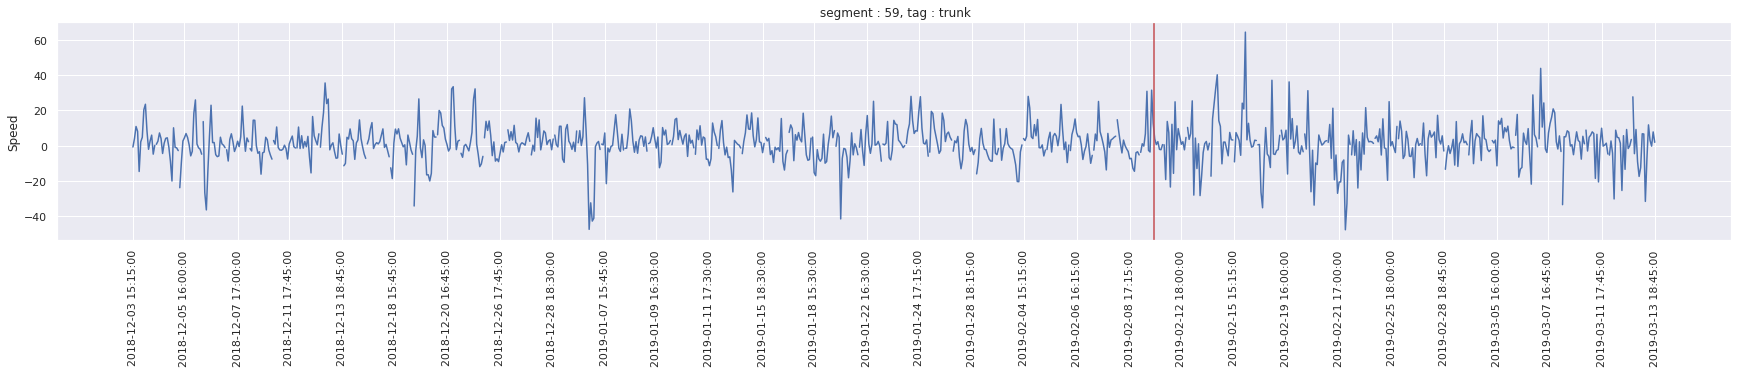

In [718]:
model_plotting.plotSegmentSeries(59,plot_error=True)

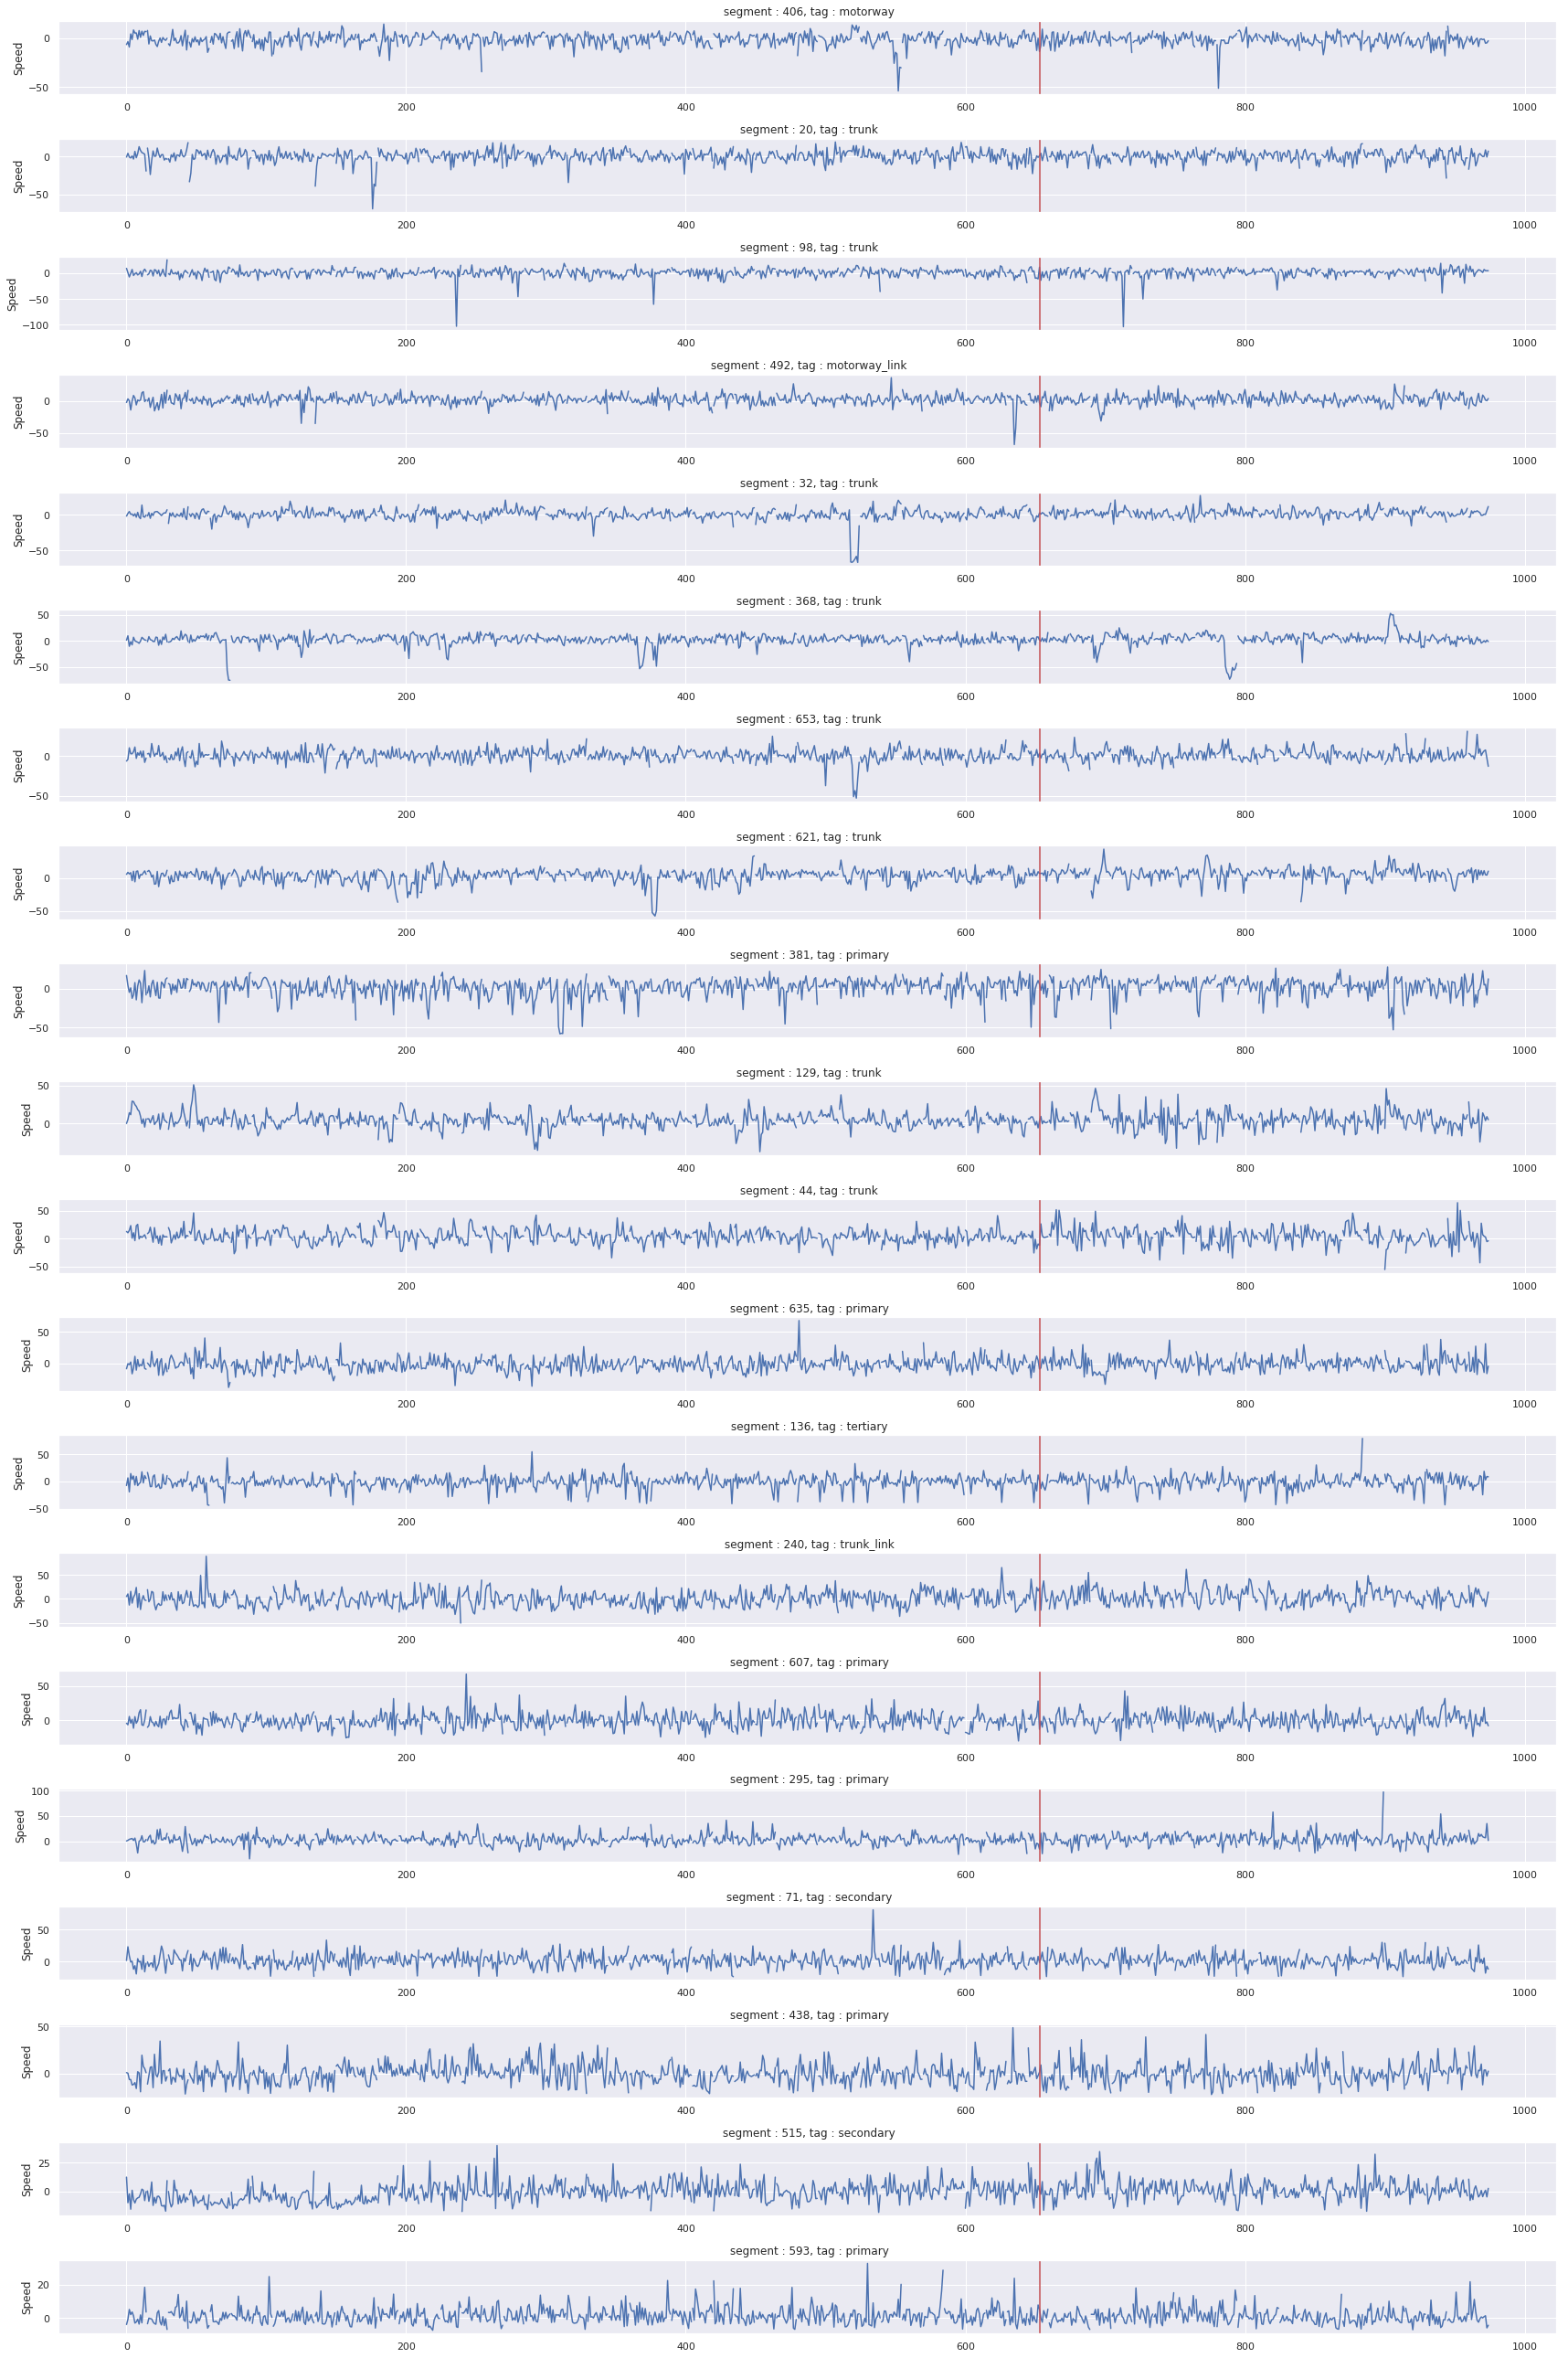

In [719]:
model_plotting.plotMultipleSegmentsSeries(plot_error=True)

In [722]:
model_plotting.plotPredictionMatchHeatMap??

Signature:
model_plotting.plotPredictionMatchHeatMap(
    split='full',
    size_rate=4,
    figsize=(10, 10),
)
Source:   
    def plotPredictionMatchHeatMap(self,split='full',size_rate=4,figsize=(10,10)):
        """
        density plot of rounded values of predictions and true data
        """
        
        train_split = int(len(self.y)*self.data_model.valid_split)
        if split.lower() == 'train':
            prdsVsYDF=pd.DataFrame([self.preds[:train_split].flatten(),self.y[:train_split].flatten()],index=['pred','y'])
        
        if split.lower()[:5]=='valid':
            prdsVsYDF=pd.DataFrame([self.preds[train_split:].flatten(),self.y[train_split:].flatten()],index=['pred','y'])
        
        if split.lower() =='full':
            prdsVsYDF=pd.DataFrame([self.preds.flatten(),self.y.flatten()],index=['pred','y'])
        prdsVsYDF=prdsVsYDF.T.astype(int)
        
        fig= plt.figure(figsize=figsize)
        gs = matplotlib.gridspec.GridSpec(size_rate, size_rate)

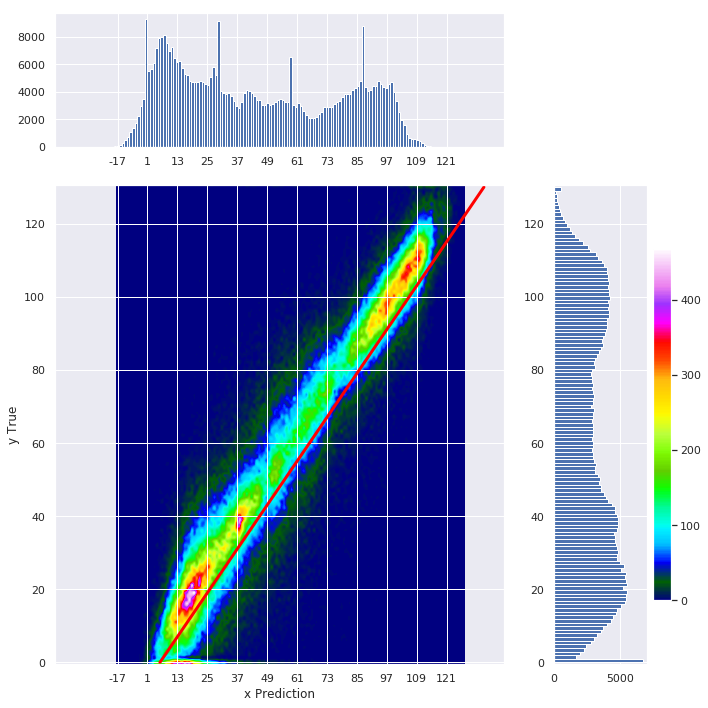

In [720]:
model_plotting.plotPredictionMatchHeatMap("train")
# saveFig()

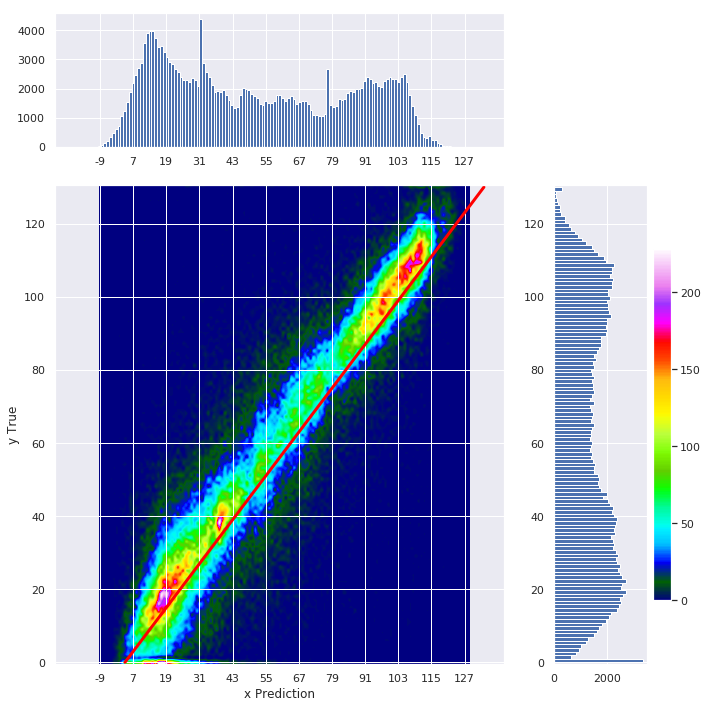

In [721]:
model_plotting.plotPredictionMatchHeatMap("valid")
# saveFig()

In [442]:
yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))

# folium_map = plotPredictions(segmentsMeta,data_model, yDF, predDF, yDF.columns[np.r_[:len(yDF.columns)-1:10j].astype(int)],mergedIndex,updatedcounts)
folium_map=folium.plugins.DualMap(location=[48.10301,-1.65537],
                    zoom_start=13,
                    tiles="OpenStreetMap")

folium.features.LinearColormap([plt.cm.brg_r(0),plt.cm.brg_r(0.5)],caption="Error rate").add_to(folium_map.m1)

folium_train_map = model_plotting.plotPredictions(yDF,predDF,yDF.columns[np.r_[8:14:1].astype(int)],folium_map=folium_map.m1)
folium_validation_map = model_plotting.plotPredictions(yDF,predDF,yDF.columns[np.r_[len(yDF.columns)*valid_split+8:len(yDF.columns)*valid_split+14:1].astype(int)],folium_map=folium_map.m2)

folium_map.save(results_path+model_name+input()+' map.html')

 pred


In [426]:
taggedPred = predDF.assign(tag = data_cleaner.segments_tags)
taggedy = yDF.assign(tag = data_cleaner.segments_tags)

In [427]:
taggedy.groupby('tag').mean()

,2018-12-03 15:15:00,2018-12-03 15:30:00,2018-12-03 15:45:00,2018-12-03 16:00:00,2018-12-03 16:15:00,2018-12-03 16:30:00,2018-12-03 16:45:00,2018-12-03 17:00:00,2018-12-03 17:15:00,2018-12-03 17:30:00,...,2019-03-13 16:30:00,2019-03-13 16:45:00,2019-03-13 17:00:00,2019-03-13 17:15:00,2019-03-13 17:30:00,2019-03-13 17:45:00,2019-03-13 18:00:00,2019-03-13 18:15:00,2019-03-13 18:30:00,2019-03-13 18:45:00
tag,,,,,,,,,,,,,,,,,,,,,
motorway,114.885387,115.823042,106.814434,118.252615,108.229856,114.509946,110.899663,113.285720,109.159587,115.432675,...,106.798598,108.851660,111.719730,116.187610,116.766256,119.939878,119.874840,119.571056,119.077945,114.014854
motorway_link,101.196567,100.678741,98.786058,97.370385,99.815600,95.976190,96.198864,98.667974,100.974444,100.252273,...,93.851443,104.143198,104.768464,103.107046,104.063615,105.004535,107.375254,105.101498,101.332428,106.102083
primary,36.458427,33.645428,33.605797,32.202251,30.713870,29.698657,31.990944,31.578286,32.804004,33.942329,...,31.779345,32.762701,34.873904,34.379100,36.779110,37.100850,36.984902,38.402502,39.653124,39.710976
primary_link,57.750000,62.250000,52.571429,44.648593,34.916667,41.666667,43.886864,47.500000,47.820753,47.300000,...,50.187500,49.220198,45.291667,46.525000,62.650000,61.660714,43.791667,24.650000,77.650000,57.000000
secondary,21.284810,22.196531,21.592573,18.638563,19.090106,17.470435,17.405648,17.877130,18.086855,22.915587,...,21.444338,24.247847,21.927456,23.372069,21.648683,23.581000,24.513936,24.902682,27.046307,25.012973
tertiary,27.336303,23.827717,23.572332,24.861386,21.378651,27.244595,20.587460,21.700893,23.990082,25.892311,...,25.550812,23.237352,26.036154,25.044137,27.210221,32.547284,28.974728,27.701570,32.292727,31.154583
trunk,88.066458,89.030301,87.999299,86.247003,82.960489,80.431234,79.992409,83.456594,84.071903,87.046641,...,81.268278,82.592452,84.103530,85.077949,89.069661,90.766724,92.433780,92.629130,93.265997,93.124613
trunk_link,65.891199,65.317593,64.121717,64.348946,57.662146,56.970032,57.915545,56.478129,58.317517,62.308328,...,57.820336,58.873630,64.011679,63.820749,64.705014,64.575990,69.869854,68.803420,68.469752,69.089297


In [723]:
pd.DataFrame((abs(predDF-yDF)).mean(axis=1)).assign(tag = data_cleaner.segments_tags).groupby('tag').describe()

0                                                    \
               count      mean       std       min       25%       50%   
tag                                                                      
motorway        11.0  6.096592  1.555930  4.160788  4.873912  6.219964   
motorway_link   10.0  6.174294  0.617507  4.835044  5.801966  6.389875   
primary        261.0  7.625463  1.983845  2.943433  6.203980  7.329113   
primary_link     2.0  9.397086  2.857771  7.376337  8.386711  9.397086   
secondary       54.0  7.788756  2.023455  4.636811  6.624944  7.427187   
tertiary        25.0  7.953111  1.986671  2.931923  7.150393  7.914113   
trunk          252.0  7.336664  2.705954  2.843182  5.350045  6.860375   
trunk_link      77.0  9.138448  3.363618  4.064826  6.900967  8.171668   

                                     
                     75%        max  
tag                                  
motorway        6.849515   9.649345  
motorway_link   6.618091   6.823899  
primary         9.107474  13.641874  
primary_link   10.407461  11.417836  
secondary       8.593819  18.122868  
tertiary        8.912781  11.993549  
trunk           8.903038  16.331427  
trunk_link     11.361868  19.217026

In [430]:
speedDF.groupby(pd.DatetimeIndex(speedDF.columns).time,axis=1).mean().assign(tag = data_cleaner.segments_tags).groupby('tag').agg(['mean'])

,14:00:00,14:15:00,14:30:00,14:45:00,15:00:00,15:15:00,15:30:00,15:45:00,16:00:00,16:15:00,16:30:00,16:45:00,17:00:00,17:15:00,17:30:00,17:45:00,18:00:00,18:15:00,18:30:00,18:45:00
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
tag,,,,,,,,,,,,,,,,,,,,
motorway,114.218203,113.994602,114.685484,114.943190,114.570339,113.953200,113.262684,113.582221,113.702615,112.242979,112.109327,111.409809,112.376675,112.556712,114.143138,115.634066,116.457525,116.623179,117.511305,117.571753
motorway_link,100.113444,101.331878,101.394659,101.678363,101.528347,101.512723,101.880393,102.167702,101.890885,101.204832,99.515989,99.324110,100.515308,100.548247,101.408666,102.922650,103.265837,103.255200,103.998540,104.632645
primary,37.415965,36.970989,37.013586,36.544769,36.322408,35.903018,35.020777,34.099420,33.165986,31.783151,31.490407,31.456734,32.220479,32.821885,34.278665,35.584295,37.065966,37.960227,39.637808,40.396124
primary_link,54.764237,54.135290,53.717408,51.532785,49.373033,54.132219,49.974020,48.988314,46.810652,43.942052,48.732082,47.822731,51.038962,47.381032,50.958022,50.993097,56.663065,53.260759,55.736812,54.016317
secondary,24.647676,24.076955,23.805754,23.800500,24.008640,23.193254,22.650782,22.212412,21.108009,20.309917,20.368335,20.075669,20.691307,21.112969,22.330744,23.348940,23.987202,25.044066,25.979513,26.426098
tertiary,25.350182,25.396425,24.762268,26.055407,25.295328,25.222829,24.522784,24.277209,22.856993,23.282234,23.413399,23.618818,24.046197,24.516842,26.270551,27.625356,28.411333,28.972455,29.390631,31.012992
trunk,89.760869,89.762234,89.657920,89.443817,89.071268,88.249692,87.654302,86.111519,84.037446,80.254059,79.120696,78.525545,79.716794,80.784126,83.390606,86.885847,89.835922,91.652415,93.312727,94.117462
trunk_link,66.301543,66.261156,65.655273,65.641518,65.143091,64.251314,62.969131,61.604271,59.918538,55.846243,55.124499,54.486199,55.402468,56.604645,58.865427,61.942978,64.549011,66.582721,68.423548,69.614101


In [434]:
speedDF.groupby(pd.DatetimeIndex(speedDF.columns).time,axis=1).std().assign(tag = data_cleaner.segments_tags).groupby('tag').agg(['mean'])

,14:00:00,14:15:00,14:30:00,14:45:00,15:00:00,15:15:00,15:30:00,15:45:00,16:00:00,16:15:00,16:30:00,16:45:00,17:00:00,17:15:00,17:30:00,17:45:00,18:00:00,18:15:00,18:30:00,18:45:00
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
tag,,,,,,,,,,,,,,,,,,,,
motorway,7.912096,8.888250,8.078706,7.800660,7.984498,8.791490,8.149227,6.846222,6.978756,8.735196,10.193286,9.967580,9.701054,9.752503,11.306565,11.857836,10.694249,12.639327,10.699322,10.770265
motorway_link,8.596078,8.785062,7.718296,7.516940,7.435489,8.151623,6.961370,7.061902,7.287369,8.916233,11.901524,11.083096,10.339683,11.080985,10.651086,9.065061,8.749908,9.627574,8.971179,9.557475
primary,10.604376,10.266321,10.348944,10.345250,10.425579,10.389459,10.260805,10.017789,10.204444,10.205035,10.209703,10.271559,10.175562,10.502273,10.378842,10.394053,10.700586,10.623506,10.534417,10.844353
primary_link,12.692130,12.179253,12.001029,11.980560,12.244792,12.316015,12.150397,11.826044,14.509833,15.804255,10.636574,13.472561,12.061916,13.583679,10.502112,11.877760,15.462118,12.220524,12.629276,12.400094
secondary,10.770300,10.462156,10.761998,10.527794,10.786793,10.719676,10.382139,10.355870,10.361769,10.478118,9.937887,9.605870,9.706636,10.061823,10.225687,10.715183,10.549297,11.380999,11.669610,11.685615
tertiary,11.024516,10.917071,10.697045,10.903007,10.828988,10.613490,10.046419,11.396231,10.306767,9.843644,11.224974,10.195260,10.533622,10.668367,10.095686,10.660554,11.998218,10.947080,11.050581,10.493429
trunk,9.565653,9.720588,9.734436,9.783569,9.541175,10.327782,10.600647,11.069022,11.767997,12.478728,13.133742,13.231893,13.621115,13.946064,13.341196,12.562078,11.216806,10.275957,9.757632,9.819798
trunk_link,10.894577,11.345029,11.174532,11.504770,11.117692,11.603393,11.983680,12.461892,13.387578,14.163877,14.754749,15.007999,15.084163,14.879296,14.070193,13.355453,12.352132,11.859370,11.357900,11.588056


In [661]:
results_path+model_name

'../images/model results/ltsm_count_time/'

In [800]:
models=reload(models)

In [704]:
model_name = "AR5/"


nSegments = len(speedDF)
input_lag, output_lag, sequence_length = 5, 1, 20
valid_split = 0.67

data_model = models.DataModel( speedDF, input_lag, output_lag, sequence_length, valid_split = valid_split)

model = models.BaseModels("AR5",speedDF[speedDF.columns[:int(len(speedDF.columns)*data_model.valid_split)]])

x_train, y_train, x_test, y_test = data_model.trainSplit()

data_model.model=model

Training the AR(5) model
Train data shape: (692, 871)

Filling the voids...
Filling done. New train data shape: (692, 6731)

Training the models...
Params: max_lag: 5


/home/infres/mbouchouia/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)



Training finished !


In [801]:
model_plotting = models.ModelPlots(data_model,data_cleaner)

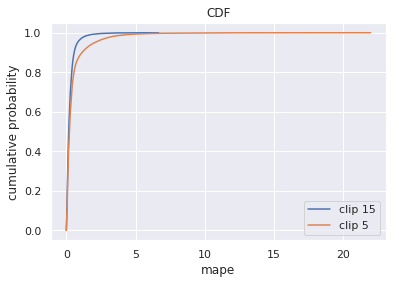

In [804]:
model_plotting.cdfPlot(label="clip 15")
model_plotting.cdfPlot(clip_value=5,label='clip 5')

In [ ]:
error.round()

../images/model results/AR5/


 error


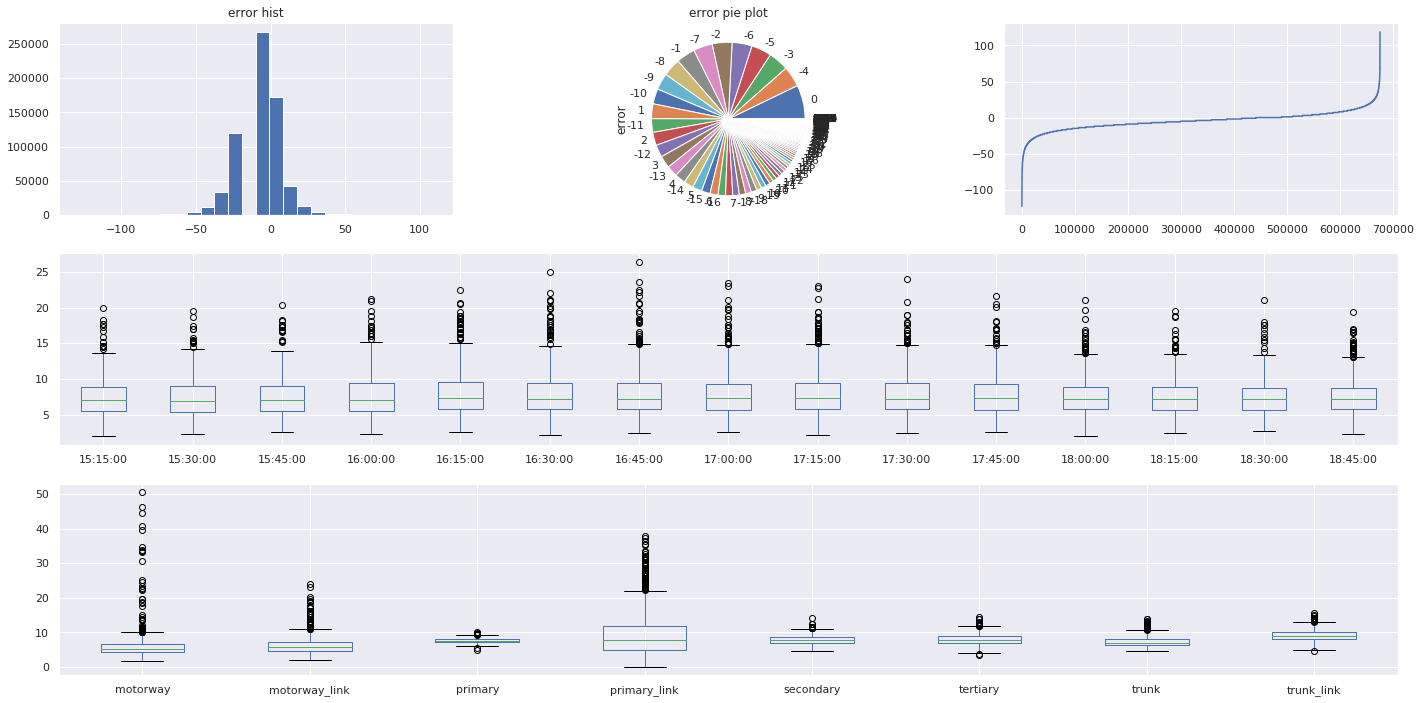

In [706]:
time_error_df  = abs(predDF-yDF).groupby(pd.DatetimeIndex(abs(predDF-yDF).columns).time,axis=1).mean()

tag_error_df  = abs(predDF-yDF).assign(tag = data_cleaner.segments_tags).groupby('tag').mean()

fig=plt.figure(figsize=(24,12))
gs = matplotlib.gridspec.GridSpec(3, 3, figure=fig)
fig.add_subplot(gs[0, 0])²
int_err = (data_model.getRawYData(data_model.predict('full')).flatten() - data_model.getRawYData(data_model.y).flatten()).astype(int)
err_series = pd.Series(int_err).value_counts()
plt.hist(int_err//10*10,bins=26);
plt.title("error hist");
fig.add_subplot(gs[0, 1])
err_series.plot("pie",label="error")
plt.title("error pie plot");
int_err.sort()
fig.add_subplot(gs[0, 2])
plt.plot(int_err)
fig.add_subplot(gs[1,:])
time_error_df.boxplot(figsize=(18,6));
fig.add_subplot(gs[2,:])
tag_error_df.T.boxplot(figsize=(18,6));
# saveFig()